In [1]:
import glob
import os

import numpy as np
import pandas as pd
from matplotlib.tri import LinearTriInterpolator, TriAnalyzer, Triangulation
from scipy.interpolate import griddata
from netCDF4 import Dataset
from osgeo import gdal, osr

In [8]:
G = np.zeros((100, 200, 300, 400))
H = G[:,-2:-1,:]
H.shape

(100, 1, 300, 400)

In [2]:
def critical_shear_stress(D_meters, rhow=1024, nu=1e-6, s=2.65, g=9.81):
    # D_meters = grain size in meters, can be array
    # rhow = density of water in kg/m3
    # nu = kinematic viscosity of water
    # s = specific gravity of sediment
    # g = acceleratin due to gravity
    Dstar = ((g * (s-1))/ nu**2)**(1/3) * D_meters
    SHcr = (0.3/(1+1.2*Dstar)) + 0.055*(1-np.exp(-0.02 * Dstar))
    taucrit = rhow * (s - 1) * g * D_meters * SHcr #in Pascals
    return taucrit

def calculate_receptor_change_percentage(receptor_filename, data_diff, ofpath):
    #gdal version
    data_diff = np.transpose(data_diff)
    data = gdal.Open(receptor_filename)
    img = data.GetRasterBand(1)
    receptor_array = img.ReadAsArray()
    # transpose to be in same orientation as NetCDF
    receptor_array[receptor_array < 0] = np.nan

    pct_mobility = {'Receptor_Value': [],
                        'Increased Deposition': [],
                        'Reduced Deposition': [],
                        'Reduced Erosion': [],
                        'Increased Erosion': [],
                        'No Change':[]}
    
    for unique_val in [i for i in np.unique(receptor_array) if ~np.isnan(i)]:
        mask = receptor_array==unique_val
        data_at_val = np.where(mask, data_diff, np.nan)
        data_at_val = data_at_val.flatten()
        data_at_val = data_at_val[~np.isnan(data_at_val)]
        ncells = data_at_val.size
        pct_mobility['Receptor_Value'].append(unique_val)
        pct_mobility['Increased Deposition'].append(100 * np.size(np.flatnonzero(data_at_val==-2))/ncells)
        pct_mobility['Reduced Deposition'].append(100 * np.size(np.flatnonzero(data_at_val>-1))/ncells)
        pct_mobility['Reduced Erosion'].append(100 * np.size(np.flatnonzero(data_at_val==1))/ncells)
        pct_mobility['Increased Erosion'].append(100 * np.size(np.flatnonzero(data_at_val==2))/ncells)
        pct_mobility['No Change'].append(100 * np.size(np.flatnonzero(data_at_val==0))/ncells)

        # print(f" Receptor Value = {unique_val}um | decrease = {pct_decrease}% | increase = {pct_increase}% | no change = {pct_nochange}%")
    DF = pd.DataFrame(pct_mobility)
    DF = DF.set_index('Receptor_Value')
    DF.to_csv(os.path.join(ofpath, 'receptor_percent_change.csv'))

def estimate_grid_spacing(x,y, nsamples=100):
    import random
    import sys
    coords = list(set(zip(x,y)))
    if nsamples != len(x):
        points = [random.choice(coords) for i in range(nsamples)] # pick N random points
    else:
        points = coords
    MD = []
    for p0x, p0y in points:
        minimum_distance = sys.maxsize
        for px, py in coords:
            distance = np.sqrt((p0x - px) ** 2 + (p0y - py) ** 2)
            if (distance < minimum_distance) & (distance !=0):
                minimum_distance = distance
        MD.append(minimum_distance)
    dxdy = np.median(MD)
    return dxdy


def calc_receptor_taucrit(receptor_filename, x, y, latlon=False):
    if ((receptor_filename is not None) or (not receptor_filename == "")):
        data = gdal.Open(receptor_filename)
        img = data.GetRasterBand(1)
        receptor_array = img.ReadAsArray()
        receptor_array[receptor_array < 0] = 0
        (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = data.GetGeoTransform()
        cols = data.RasterXSize
        rows = data.RasterYSize
        r_rows = np.arange(rows) * y_size + upper_left_y + (y_size / 2)
        r_cols = np.arange(cols) * x_size + upper_left_x + (x_size / 2)
        if latlon==True:
            r_cols = np.where(r_cols<0, r_cols+360, r_cols)
        x_grid, y_grid = np.meshgrid(r_cols, r_rows)
        receptor_array = griddata((x_grid.flatten(), y_grid.flatten()), receptor_array.flatten(), (x,y), method='nearest', fill_value=0)

        taucrit = critical_shear_stress(D_meters=receptor_array * 1e-6,
                            rhow=1024,
                            nu=1e-6,
                            s=2.65,
                            g=9.81) #units N/m2 = Pa
    else:
        # taucrit without a receptor
        #Assume the following grain sizes and conditions for typical beach sand (Nielsen, 1992 p.108)
        taucrit = critical_shear_stress(D_meters=200*1e-6, rhow=1024, nu=1e-6, s=2.65, g=9.81)  #units N/m2 = Pa
    return taucrit, receptor_array

def create_structured_array_from_unstructured(x, y, z, dxdy, flatness=0.2):
    # flatness is from 0-.5 .5 is equilateral triangle
    refx = np.arange(np.nanmin(x), np.nanmax(x)+dxdy, dxdy)
    refy = np.arange(np.nanmin(y), np.nanmax(y)+dxdy, dxdy)
    refxg, refyg = np.meshgrid(refx, refy)
    tri = Triangulation(x, y)
    mask = TriAnalyzer(tri).get_flat_tri_mask(flatness)
    tri.set_mask(mask)
    tli = LinearTriInterpolator(tri, z)
    z_interp = tli(refxg, refyg)
    return refxg, refyg, z_interp.data

def classify_mobility(mobility_parameter_dev, mobility_parameter_nodev):
    mobility_classification = np.zeros(mobility_parameter_dev.shape)
    #Reduced Erosion (Tw<Tb) & (Tw-Tb)>1
    mobility_classification = np.where(((mobility_parameter_dev < mobility_parameter_nodev) & (mobility_parameter_nodev>=1)), 1, mobility_classification)
    #Increased Erosion (Tw>Tb) & (Tw-Tb)>1
    mobility_classification = np.where(((mobility_parameter_dev > mobility_parameter_nodev) & (mobility_parameter_nodev>=1)), 2, mobility_classification)
    #Reduced Deposition (Tw>Tb) & (Tw-Tb)<1
    mobility_classification = np.where(((mobility_parameter_dev > mobility_parameter_nodev) & (mobility_parameter_nodev<1)), -1, mobility_classification)
    #Increased Deposition (Tw>Tb) & (Tw-Tb)>1
    mobility_classification = np.where(((mobility_parameter_dev < mobility_parameter_nodev) & (mobility_parameter_nodev<1)), -2, mobility_classification)
    #NoChange = 0
    return mobility_classification

In [3]:
fpath_nodev = r"H:\Projects\C1308_SEAT\SEAT_inputs\plugin-input\WEC DEMO shear stress\devices-not-present"
fpath_dev = r"H:\Projects\C1308_SEAT\SEAT_inputs\plugin-input\WEC DEMO shear stress\devices-present"
probabilities_file = r"H:\Projects\C1308_SEAT\SEAT_inputs\plugin-input\WEC DEMO shear stress\boundary-condition\boundary-conditions.csv"
latlon=True
receptor_filename = r"H:\Projects\C1308_SEAT\SEAT_inputs\plugin-input\WEC DEMO shear stress\receptor\grainsize_receptor.tif"


In [4]:
# import xarray as xr
# file_dev_notpresent = xr.open_dataset(os.path.join(fpath_dev, files_dev[0]))

In [5]:
# file = 'This_is_a_test_02_map.nc'
# int(file.split('.')[0].split('_')[-2])

In [6]:
def check_grid_define_vars(dataset):
    vars = list(file_dev_present.variables)
    if 'XCOR' in vars:
        gridtype = 'structured'
        xvar = 'XCOR'
        yvar = 'YCOR'
        tauvar = 'TAUMAX'
    else:
        gridtype = 'unstructured'
        xvar = 'FlowElem_xcc'
        yvar = 'FlowElem_ycc'
        tauvar = 'taus'
    return gridtype, xvar, yvar, tauvar

In [7]:
# check_grid_define_vars(file_dev_present)

In [13]:
files_nodev = [i for i in os.listdir(fpath_nodev) if i.endswith('.nc')]
files_dev = [i for i in os.listdir(fpath_dev) if i.endswith('.nc')]

# Load and sort files
if len(files_nodev) == 1 & len(files_dev) ==1: 
    #asumes a concatonated files with shape
    #[run_order, time, rows, cols]

    file_dev_present = Dataset(os.path.join(fpath_dev, files_dev[0]))
    gridtype, xvar, yvar, tauvar = check_grid_define_vars(file_dev_present)
    # X-coordinate of cell center
    xcor = file_dev_present.variables[xvar][:].data
    # Y-coordinate of cell center
    ycor = file_dev_present.variables[yvar][:].data
    # TAUMAX
    tau_dev = file_dev_present.variables[tauvar][:]
    # close the device prsent file
    file_dev_present.close()

    file_dev_notpresent = Dataset(os.path.join(fpath_nodev, files_nodev[0]))
    tau_nodev = file_dev_notpresent.variables[tauvar][:]
    # close the device not present file
    file_dev_notpresent.close()
    
    # if tau_dev.shape[0] != tau_nodev.shape[0]:
    #     raise Exception(f"Number of device runs ({tau_dev.shape[0]}) must be the same as no device runs ({tau_nodev.shape[0]}).") 

elif len(files_nodev) == 1 & len(files_dev): 
    #asumes each run is separate with the some_name_RunNum_map.nc, where run number comes at the last underscore before _map.nc
    runorder_nodev = np.zeros((len(files_nodev)))
    for ic, file in enumerate(files_nodev):
        runorder_nodev[ic] = int(file.split('.')[0].split('_')[-2])
    runorder_dev = np.zeros((len(files_dev)))
    for ic, file in enumerate(files_dev):
        runorder_dev[ic] = int(file.split('.')[0].split('_')[-2])

    #ensure run oder for nodev matches dev files
    if np.any(runorder_nodev != runorder_dev):
        adjust_dev_order = []
        for ri in runorder_nodev:
            adjust_dev_order = np.append(adjust_dev_order, np.flatnonzero(runorder_dev == ri))
        files_dev = [files_dev[int(i)] for i in adjust_dev_order]
        runorder_dev = [runorder_dev[int(i)] for i in adjust_dev_order]
    DF = pd.DataFrame({'files_nodev':files_nodev, 
                'run_order_nodev':runorder_nodev,
                'files_dev':files_dev,
                'run_order_dev':runorder_dev})
    DF = DF.sort_values(by=runorder_nodev)

    first_run = True
    ir = 0
    for _, row in DF.iterrows():
        file_dev_notpresent = Dataset(os.path.join(fpath_nodev, row.files_nodev))
        file_dev_present = Dataset(os.path.join(fpath_dev, row.files_dev))

        gridtype, xvar, yvar, tauvar = check_grid_define_vars(file_dev_present)

        if first_run:
            tmp = file_dev_notpresent.variables[tauvar].data
            tau_nodev = np.zeros(DF.shape[0], tmp.shape[0], tmp.shape[1], tmp.shape[2])
            tau_dev = np.zeros(DF.shape[0], tmp.shape[0], tmp.shape[1], tmp.shape[2])
            xcor = file_dev_notpresent.variables[xvar][:].data
            ycor = file_dev_notpresent.variables[yvar][:].data            
            first_run = False
        tau_nodev = file_dev_notpresent.variables[tauvar].data
        tau_dev = file_dev_present.variables[tauvar].data
        ir += 1
else:
    raise Exception(f"Number of device runs ({len(files_dev)}) must be the same as no device runs ({len(files_nodev)}).") 
# Finished loading and sorting files

# Load BC file with probabilities and find appropriate probability
BC_probability = pd.read_csv(probabilities_file, delimiter=",")
BC_probability['run order'] = BC_probability['run order']-1
BC_probability = BC_probability.sort_values(by='run order')
BC_probability["% of yr"]= BC_probability["% of yr"].values/100
# BC_probability
if 'Exclude' in BC_probability.columns:
    BC_probability = BC_probability[~((BC_probability['Exclude'] == 'x') | (BC_probability['Exclude'] == 'X'))]

# Calculate Stressor and Receptors
# data_dev_max = np.amax(data_dev, axis=1, keepdims=True) #look at maximum shear stress difference change
tau_dev_max = np.amax(tau_dev, axis=1, keepdims=True) #max over time
tau_nodev_max = np.amax(tau_nodev, axis=1, keepdims=True) #max over time

#initialize arrays
taumax_combined_nodev = np.zeros(np.shape(tau_nodev[0, 0, :, :]))
taumax_combined_dev = np.zeros(np.shape(tau_dev[0, 0, :, :]))

for run_number, prob in zip(BC_probability['run order'].values,
                             BC_probability["% of yr"].values):
        
    taumax_combined_nodev = taumax_combined_nodev + prob * tau_nodev_max[run_number,-1,:,:] #tau_max #from last model run
    taumax_combined_dev = taumax_combined_dev + prob * tau_dev_max[run_number,-1,:,:] #tau_max #from maximum of timeseries

tau_diff = taumax_combined_dev - taumax_combined_nodev
taucrit, receptor_array = calc_receptor_taucrit(receptor_filename, xcor, ycor, latlon=True)
mobility_parameter_nodev = taumax_combined_nodev / taucrit
mobility_parameter_nodev = np.where(receptor_array==0, 0, mobility_parameter_nodev)
mobility_parameter_dev = taumax_combined_dev / taucrit
mobility_parameter_dev = np.where(receptor_array==0, 0, mobility_parameter_dev)
# Calculate risk metrics over all runs

mobility_parameter_diff = mobility_parameter_dev - mobility_parameter_nodev

if gridtype=='structured':
    mobility_classification = classify_mobility(mobility_parameter_dev, mobility_parameter_nodev)
    listOfFiles = [tau_diff, mobility_parameter_nodev, mobility_parameter_dev, mobility_parameter_diff, mobility_classification]
    dx = np.nanmean(np.diff(xcor[:,0]))
    dy = np.nanmean(np.diff(ycor[0,:]))
    rx = xcor
    ry = ycor
else: # unstructured
    dxdy = estimate_grid_spacing(xcor,ycor, nsamples=100)
    dx = dxdy
    dy = dxdy
    rx, ry, tau_diff_struct = create_structured_array_from_unstructured(xcor, ycor, tau_diff, dxdy, flatness=0.2)
    _, _, mobility_parameter_nodev_struct = create_structured_array_from_unstructured(xcor, ycor, mobility_parameter_nodev, dxdy, flatness=0.2)
    _, _, mobility_parameter_dev_struct = create_structured_array_from_unstructured(xcor, ycor, mobility_parameter_dev, dxdy, flatness=0.2)
    _, _, mobility_parameter_diff_struct = create_structured_array_from_unstructured(xcor, ycor, mobility_parameter_diff, dxdy, flatness=0.2)
    mobility_classification = classify_mobility(mobility_parameter_dev_struct, mobility_parameter_nodev_struct)
    listOfFiles = [tau_diff_struct, mobility_parameter_nodev_struct, mobility_parameter_dev_struct, mobility_parameter_diff_struct, mobility_classification]

# return listOfFiles, rx, ry, dxdy, dxdy

In [9]:
fig,ax = plt.subplots(ncols=3)
runix = 17
ax[0].pcolormesh(tau_nodev[runix,0,:,:])
ax[1].pcolormesh(tau_nodev[runix,-1,:,:])
ax[2].pcolormesh(tau_nodev_max[runix,-1,:,:])

NameError: name 'plt' is not defined

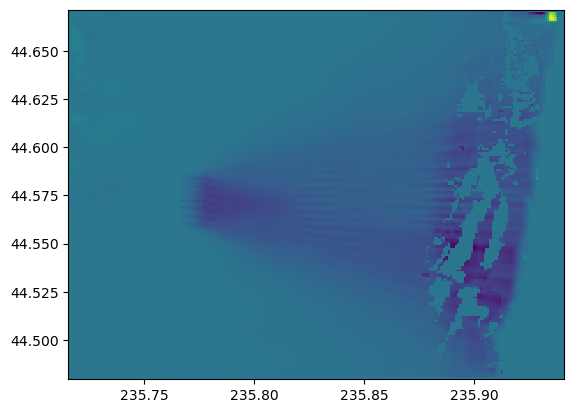

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.pcolormesh(rx,ry,mobility_parameter_diff)

In [ ]:

# # data_dev_max = np.amax(data_dev, axis=1, keepdims=True) #look at maximum shear stress difference change
# tau_dev_max = np.amax(tau_dev, axis=1, keepdims=True) #max over time
# tau_nodev_max = np.amax(tau_dev, axis=1, keepdims=True) #max over time

# #initialize arrays
# taumax_combined_nodev = np.zeros(np.shape(tau_nodev[0, 0, :, :]))
# taumax_combined_dev = np.zeros(np.shape(tau_dev[0, 0, :, :]))

# for run_number, prob in zip(BC_probability['run order'].values,
#                              BC_probability["% of yr"].values):
        
#     taumax_combined_nodev = taumax_combined_nodev + prob * tau_nodev_max[run_number,-1,:,:] #tau_max #from last model run
#     taumax_combined_dev = taumax_combined_dev + prob * tau_dev_max[run_number,-1,:,:] #tau_max #from maximum of timeseries

# tau_diff = taumax_combined_dev - taumax_combined_nodev
# taucrit, receptor_array = calc_receptor_taucrit(receptor_filename, xcor, ycor, latlon=True)
# mobility_parameter_nodev = taumax_combined_nodev / taucrit
# mobility_parameter_nodev = np.where(receptor_array==0, 0, mobility_parameter_nodev)
# mobility_parameter_dev = taumax_combined_dev / taucrit
# mobility_parameter_dev = np.where(receptor_array==0, 0, mobility_parameter_dev)
# # Calculate risk metrics over all runs

# mobility_parameter_diff = mobility_parameter_dev - mobility_parameter_nodev

# if gridtype=='structured':
#     mobility_classification = classify_mobility(mobility_parameter_dev, mobility_parameter_nodev)
#     listOfFiles = [tau_diff, mobility_parameter_nodev, mobility_parameter_dev, mobility_parameter_diff, mobility_classification]
#     dx = np.nanmean(np.diff(xcor[:,0]))
#     dy = np.nanmean(np.diff(ycor[0,:]))
#     rx = xcor
#     ry = ycor
# else: # unstructured
#     dxdy = estimate_grid_spacing(xcor,ycor, nsamples=100)
#     rx, ry, tau_diff_struct = create_structured_array_from_unstructured(xcor, ycor, tau_diff, dxdy, flatness=0.2)
#     _, _, mobility_parameter_nodev_struct = create_structured_array_from_unstructured(xcor, ycor, mobility_parameter_nodev, dxdy, flatness=0.2)
#     _, _, mobility_parameter_dev_struct = create_structured_array_from_unstructured(xcor, ycor, mobility_parameter_dev, dxdy, flatness=0.2)
#     _, _, mobility_parameter_diff_struct = create_structured_array_from_unstructured(xcor, ycor, mobility_parameter_diff, dxdy, flatness=0.2)
#     mobility_classification = classify_mobility(mobility_parameter_dev_struct, mobility_parameter_nodev_struct)
#     listOfFiles = [tau_diff_struct, mobility_parameter_nodev_struct, mobility_parameter_dev_struct, mobility_parameter_diff_struct, mobility_classification]

